## Loading Packages

In [65]:
# yellowbrick version too old
!pip install -U yellowbrick

In [66]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load
from yellowbrick.cluster.elbow import kelbow_visualizer

# NLP 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec
import gensim

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils, layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Ensemble
import xgboost
from sklearn.ensemble import RandomForestClassifier

# Support
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edmun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [67]:
# wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Settings

In [68]:
#SETTINGS
RANDOM_STATE = 42

#DATASET
TRAIN_SIZE = 0.8

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# TENSORFLOW
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

## Loading Datasets

In [69]:
train_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Train.csv")
val_ds = pd.read_csv("https://raw.githubusercontent.com/edologgerbird/BT4222_project/main/data/Constraint_Val.csv")
df = pd.concat([train_ds,val_ds])

In [70]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [71]:
df.label.unique()

array(['real', 'fake'], dtype=object)

In [72]:
df = df.drop('id', axis=1)

## Sanity Check
In this section, we check for:
1.   Null inputs
2.   Duplicated rows



In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8560 entries, 0 to 2139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   8560 non-null   object
 1   label   8560 non-null   object
dtypes: object(2)
memory usage: 200.6+ KB


No null inputs were found

In [74]:
df.duplicated().sum()

1

Viewing the duplicated entry

In [75]:
 df[df.duplicated(keep=False)]

,tweet,label
5458,Our combined total of confirmed and probable c...,real
909,Our combined total of confirmed and probable c...,real


In [76]:
df = df.drop_duplicates()

1 Duplicate was found and dropped

In [77]:
df.label.value_counts()

real    4479
fake    4080
Name: label, dtype: int64

<AxesSubplot:>

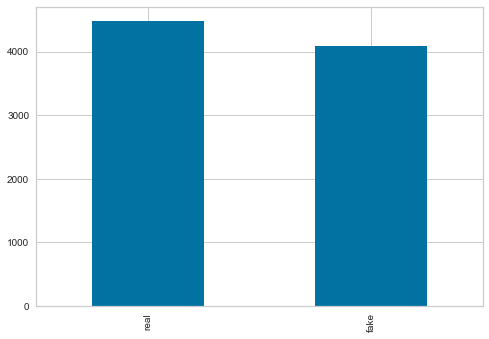

In [78]:
df.label.value_counts().plot(kind='bar')

## Pre-processing

In [79]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()

In [80]:
", ".join(stop_words)


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

## Previewing Tweets

In [81]:
print(df.tweet.sample(15).values)

['In Italy, 232 children have died from COVID-19'
 "The latest update from the Ministry of Health - Manatū Hauora:\u2063 \u2063 • Today there is one new confirmed case of COVID-19 to report in New Zealand. \u2063 \u2063 • The case is linked to the St Margaret's cluster in Auckland and is a household contact of an earlier case.\u2063 https://t.co/xM9ZIuIhQ5"
 "Snap analysis of this: it is a relief that California has tested ~40000 more people than we knew until an hour ago. That said it's a huge state and we don't know how many of those tests are still pending (based on CA's previous reporting it could be *a lot*)."
 'Our daily update is published. States reported 724k tests and 44k cases. The death toll today is 1073. https://t.co/3hoJNhqO86'
 'A Chinese report has mapped the COVID19 outbreak n for some reason seems to indicate epicentres around 40Deg latitude - co-incidence or is there something to be researched? Southern Hemisphere seems to be unaffected as yet!'
 'Update from @minhe

Creating a column for word count

In [82]:
df['length'] = df['tweet'].apply(lambda x: len(x.split()))

Visualising word count

In [83]:
df['length'].describe()

count    8559.000000
mean       26.945788
std        22.451425
min         3.000000
25%        15.000000
50%        25.000000
75%        37.000000
max      1456.000000
Name: length, dtype: float64

<AxesSubplot:>

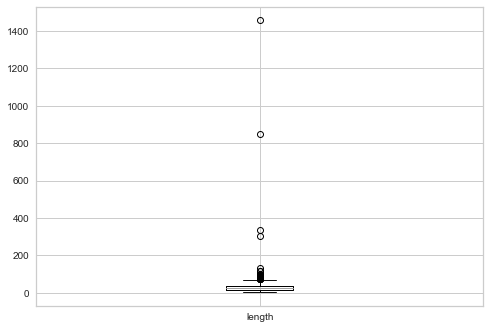

In [84]:
df.boxplot(column=['length'])

We notice outliers with extreme number of words. Previewing outlier articles here.

In [85]:
df[df['length']>150]

,tweet,label,length
270,"Amoxi"" Capsule made in US is the only medicine...",fake,1456
1109,"Actors"" applauded Macron when he visited the s...",fake,847
6306,Man visited Albany N.Y. days before dying from...,fake,336
1733,I'm so happy that we’re able to do something v...,real,304


We will retain the outlier articles.

(0.0, 200.0)

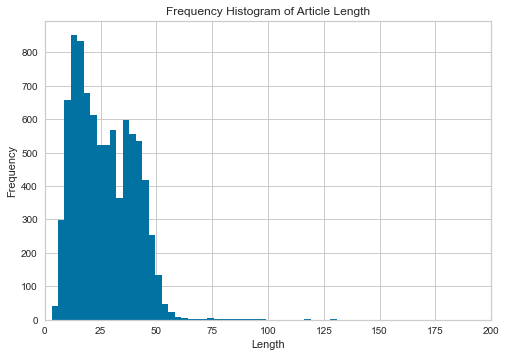

In [86]:
#plt.scatter(df.index,df['length'])
plt.hist(df['length'],bins=500)
plt.gca().set(title='Frequency Histogram of Article Length', ylabel='Frequency', xlabel='Length')
plt.xlim(0,200)


## Text Cleaning

- Transform to lowercase
- Remove trailing white spaces
- Remove stopwords
- Stem and lemmatize words to root form

In [87]:
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmer.lemmatize(stemmer.stem(token)))
    return " ".join(tokens)

In [88]:
df.tweet = df.tweet.apply(lambda x:preprocess(x))

In [89]:
print(df.tweet.sample(15).values)

['new sept 15 interview fox news air conspiraci theori debunk sinc begin coronavirus pandem'
 'mean number activ case new zealand remain 22 activ case recent return oversea manag isol facil case communiti transmiss'
 'andrew jenkinson say wife treatment paus much concentr covid 19 get stori'
 '1st week feb began ship test 150 lab around enabl countri quick identifi track amp trace covid19 drtedro'
 '2 4 contain zone refer specif geograph area posit case coronavirus found dynam natur fit nation repres sampl indiafightscovid19'
 'indiafightscorona csir ind amp mylan laboratori ltd announc partnership identifi advanc therapeut option manag covid19 seri clinic trial conduct toward new innov solut manag covid 19 pandem india staysaf'
 'whatsapp chain sent doctor vall hebron hospit barcelona coronavirus'
 'everyon react differ stress situat find way practic selfcar help reduc stress covid19 pandem find way cope stress'
 'differ ihm covid act project expect result differ approach model earli 

## Train Test Split

In [90]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)
print("TRAIN size: ", len(df_train))
print("TEST size: ", len(df_test))

TRAIN size:  6847
TEST size:  1712


In [91]:
df_train.head()

,tweet,label,length
5250,florida man work home clock watch wish end wor...,fake,16
2041,cdc director robert redfield say healthi peopl...,fake,11
1235,news coronavirus agre stay shop 24th juli,fake,13
847,covid 19 updat 9 new confirm case covid 19 com...,real,49
1766,releas short total number activ case 134 21 im...,real,40


## Word2Vec Model

### Building Document

In [92]:
documents = [tweet.split() for tweet in df_train.tweet]


### Initialising word2vec model with hyperparameters

In [93]:
# w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
#                                             window=W2V_WINDOW, 
#                                             min_count=W2V_MIN_COUNT, 
#                                             workers=8)

# For newer version of word2vec
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

### Building Vocab

In [94]:
w2v_model.build_vocab(documents)


### Training word2vec model

In [95]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


(2708448, 3827904)

In [96]:
w2v_model.wv.most_similar("covid")


[('coronaupd', 0.42825451493263245),
 ('covidupd', 0.3868418037891388),
 ('coronavirusindia', 0.3840523958206177),
 ('rash', 0.34896788001060486),
 ('drhvoffic', 0.32746610045433044),
 ('combin', 0.3262650966644287),
 ('coronaviruspandem', 0.31542718410491943),
 ('suspect', 0.2979760766029358),
 ('95', 0.2965315580368042),
 ('covid19india', 0.2926141321659088)]

## Tokenize Text

In [97]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total unique words", vocab_size)

Total unique words 10963


Previewing top 50 words

In [98]:
token_count = dict(tokenizer.word_counts)
token_count_df = pd.DataFrame(dict(sorted(token_count.items(), key=lambda item: item[1], reverse=True)),index=["Count"]).T
token_count_df.head(2)

,Count
covid,2573
case,2204


### Converting text to sequence of integers

In [99]:
x_train_word2vec = tokenizer.texts_to_sequences(df_train.tweet)
x_test_word2vec = tokenizer.texts_to_sequences(df_test.tweet)

## Padding

In [100]:
x_train_word2vec  = pad_sequences(x_train_word2vec , maxlen=SEQUENCE_LENGTH)
x_test_word2vec  = pad_sequences(x_test_word2vec , maxlen=SEQUENCE_LENGTH)

## Label Encoding

In [101]:
labels = df_train.label.unique().tolist()
labels

['fake', 'real']

In [102]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train_word2vec  = encoder.transform(df_train.label.tolist())
y_test_word2vec  = encoder.transform(df_test.label.tolist())

y_train_word2vec  = y_train_word2vec .reshape(-1,1)
y_test_word2vec  = y_test_word2vec .reshape(-1,1)


In [103]:
print("x_train", x_train_word2vec .shape)
print("y_train", y_train_word2vec .shape)

print("x_test", x_test_word2vec .shape)
print("y_test", y_test_word2vec .shape)

x_train (6847, 300)
y_train (6847, 1)
x_test (1712, 300)
y_test (1712, 1)


## Embedding Matrix

In [104]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Weights for embedding layer

In [105]:
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(10963, 300)


## TF-IDF Vectorisation

In [106]:
documents = [tweet.split() for tweet in df_train.tweet]

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(df_train.tweet)
x_test_tfidf = tfidf_vectorizer.transform(df_test.tweet)

df_tfidf_sklearn = pd.DataFrame(x_train_tfidf.toarray(),columns=tfidf_vectorizer.get_feature_names())
df_tfidf_sklearn.sort_index().round(decimals=5)
df_tfidf_sklearn



C:\Users\edmun\anaconda3\envs\gpuEnv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,006,00ice,00pm,01,0141,02,03,033,...,zone,zoo,zoodirector,zookeep,zoolog,zoom,zoonot,zuckoff,zurich,zydus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
df_tfidf_sklearn = df_tfidf_sklearn.stack().reset_index()
df_tfidf_sklearn = df_tfidf_sklearn.rename(columns={0:'tfidf', 'level_0': 'id','level_1': 'term', 'level_2': 'term'})
df_tfidf_sklearn

,id,term,tfidf
0,0,00,0.0
1,0,000,0.0
2,0,006,0.0
3,0,00ice,0.0
4,0,00pm,0.0
...,...,...,...
74844552,6846,zoom,0.0
74844553,6846,zoonot,0.0
74844554,6846,zuckoff,0.0
74844555,6846,zurich,0.0


In [109]:
df_tfidf_sklearn.sort_values(by=['id','tfidf'], ascending=[True,False]).groupby(['id']).head(10)


,id,term,tfidf
10801,0,work,0.423296
9072,0,selfisol,0.398456
10776,0,wish,0.398456
3394,0,clock,0.385331
10649,0,watch,0.291903
...,...,...,...
74842634,6846,scientist,0.302777
74836918,6846,china,0.267353
74842522,6846,said,0.251956
74837291,6846,coronavirus,0.131603


In [110]:
specificid = df_tfidf_sklearn.sort_values(by=['id','tfidf'], ascending=[True,False]).groupby(['id']).head(20)
specificid[specificid['id'].isin({847})]


,id,term,tfidf
9261503,847,brought,0.323354
9268620,847,told,0.313591
9267843,847,sky,0.309388
9268591,847,tip,0.294129
9266641,847,point,0.277362
9267610,847,secretari,0.258628
9267861,847,slow,0.252375
9267236,847,restrict,0.242417
9265478,847,measur,0.241024
9268809,847,uk,0.239229


# BERT Vectorisation

## Exploratory Data Analysis

### Kmeans Clustering

### Cluster on words

In [111]:
X = w2v_model.wv.vectors
kmeans = KMeans(random_state = 42)

In [112]:
#kelbow_visualizer(kmeans, X)

### Cluster on Documents

In [113]:
#kelbow_visualizer(kmeans, response, k=(1,20))

K-means clustering doesn't seem to work sell for both words and documents. The variety in meanings (of words) and topics (for documents) is probably the reason why we get a fairly smooth curve plot with the elbow method

### Cluster on words

K-means clustering doesn't seem to work sell for both words and documents. The variety in meanings (of words) and topics (for documents) is probably the reason why we get a fairly smooth curve plot with the elbow method

### Word Cloud


In [114]:
#cloud_stop = stop_words.extend(["covid", "coronavirus", "case", "covid-19", "peopl", "covid19"])
cloud_stop = set(STOPWORDS)
cloud_stop.update(["covid", "coronavirus", "case", "covid-19", "peopl", "covid19", "amp"])

In [115]:
# for all text
all_text = " ".join(tweet for tweet in df.tweet)
wordcloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(all_text)

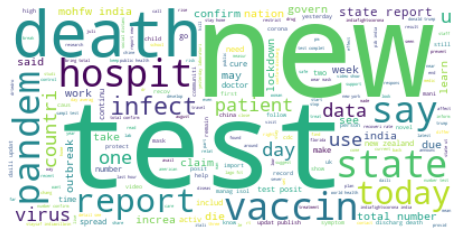

In [116]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [117]:
# for fakes
fake_text = " ".join(tweet for tweet in df[df['label']== 'fake'].tweet)
fake_cloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(fake_text)

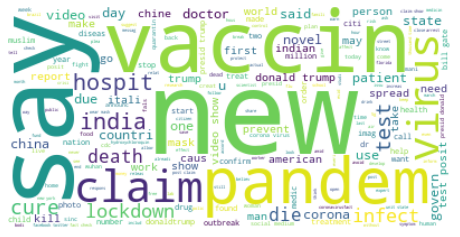

In [118]:
plt.imshow(fake_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [119]:
# for real
real_text = " ".join(tweet for tweet in df[df['label']== 'real'].tweet)
real_cloud = WordCloud(stopwords=cloud_stop, background_color="white").generate(real_text)

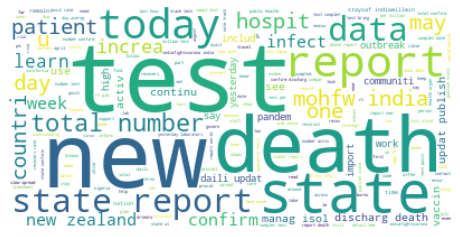

In [120]:
plt.imshow(real_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Model Building

## Deep Learning : TextCNN

### Using Word2Vec Vectorisation

In [121]:
cnn_word2vec_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    layers. Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_word2vec_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          3288900   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 128)          192128    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 3,482,329
Trainable params: 193,429
Non-trainable params: 3,288,900
_________________________________________________________________


In [174]:
cnn_word2vec_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = cnn_word2vec_model.fit(x_train_word2vec , y_train_word2vec ,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/32
7/7 [==============================] - 2s 227ms/step - loss: 0.1323 - accuracy: 0.9542 - precision: 0.9673 - recall: 0.9453 - auc: 0.9903 - val_loss: 0.2337 - val_accuracy: 0.9212 - val_precision: 0.9071 - val_recall: 0.9432 - val_auc: 0.9696
Epoch 2/32
7/7 [==============================] - 1s 165ms/step - loss: 0.1066 - accuracy: 0.9667 - precision: 0.9784 - recall: 0.9582 - auc: 0.9940 - val_loss: 0.2246 - val_accuracy: 0.9168 - val_precision: 0.9178 - val_recall: 0.9205 - val_auc: 0.9701
Epoch 3/32
7/7 [==============================] - 1s 166ms/step - loss: 0.0966 - accuracy: 0.9716 - precision: 0.9768 - recall: 0.9693 - auc: 0.9950 - val_loss: 0.2222 - val_accuracy: 0.9139 - val_precision: 0.9246 - val_recall: 0.9062 - val_auc: 0.9710
Epoch 4/32
7/7 [==============================] - 1s 167ms/step - loss: 0.0925 - accuracy: 0.9721 - precision: 0.9889 - recall: 0.9579 - auc: 0.9962 - val_loss: 0.2310 - val_accuracy: 0.9080 - val_precision: 0.9070 - val_recall: 0.9148 - 

In [124]:
score_cnn_word2vec = cnn_word2vec_model.evaluate(x_test_word2vec , y_test_word2vec , batch_size=BATCH_SIZE)
print()

print("LOSS:",score[0])
print("ACCURACY:",score[1])
print("PRECISION:",score[2])
print("RECALL:",score[3])
print("AUC:",score[4])

2/2 [==============================] - 0s 65ms/step - loss: 0.2383 - accuracy: 0.8972 - precision: 0.9085 - recall: 0.8876 - auc: 0.9665

LOSS: 0.23832188546657562
ACCURACY: 0.8971962332725525
PRECISION: 0.908450722694397
RECALL: 0.8876146674156189
AUC: 0.9664883613586426


## Using TF-IDF Vectorisation

In [216]:
cnn_tfidf_model = tf.keras.Sequential([
    layers.Conv1D(128, 5, activation='relu', input_shape=(None,1)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_tfidf_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, None, 128)         768       
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 11        
Total params: 2,069
Trainable params: 2,069
Non-trainable params: 0
_________________________________________________________________


In [217]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[min(index_batch):max(index_batch)+1]
        counter += 1
        X_batch = np.expand_dims(X_batch, axis=2)
        #print(X_batch.shape)
        yield X_batch, np.array(y_batch)
        if (counter > number_of_batches):
            counter=0

In [222]:
y_train = list(y_train_word2vec)

In [239]:
cnn_tfidf_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy','Precision','Recall','AUC'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = cnn_tfidf_model.fit(batch_generator(x_train_tfidf, y_train, 32),epochs=10,steps_per_epoch=x_train_tfidf.shape[0]/32)

Epoch 1/10
213/213 [==============================] - 19s 79ms/step - loss: 0.6517 - accuracy: 0.6197 - precision: 0.6237 - recall: 0.7011 - auc: 0.6586
Epoch 2/10
213/213 [==============================] - 16s 73ms/step - loss: 0.6516 - accuracy: 0.6198 - precision: 0.6233 - recall: 0.7036 - auc: 0.6587
Epoch 3/10
213/213 [==============================] - 17s 81ms/step - loss: 0.6515 - accuracy: 0.6197 - precision: 0.6231 - recall: 0.7036 - auc: 0.6586
Epoch 4/10
213/213 [==============================] - 17s 77ms/step - loss: 0.6515 - accuracy: 0.6194 - precision: 0.6233 - recall: 0.7014 - auc: 0.6587
Epoch 5/10
213/213 [==============================] - 18s 86ms/step - loss: 0.6515 - accuracy: 0.6187 - precision: 0.6226 - recall: 0.7011 - auc: 0.6586
Epoch 6/10
213/213 [==============================] - 17s 78ms/step - loss: 0.6515 - accuracy: 0.6188 - precision: 0.6234 - recall: 0.6984 - auc: 0.6588
Epoch 7/10
213/213 [==============================] - 18s 84ms/step - loss: 0.6514

In [228]:
x_test_tfidf = np.expand_dims(x_test_tfidf.toarray(), axis=2)

In [241]:
score_cnn_tfidf = cnn_tfidf_model.evaluate(x_test_tfidf, y_test_word2vec, batch_size=32)

print()

print("LOSS:",score_cnn_tfidf [0])
print("ACCURACY:",score_cnn_tfidf [1])
print("PRECISION:",score_cnn_tfidf [2])
print("RECALL:",score_cnn_tfidf [3])
print("AUC:",score_cnn_tfidf [4])

54/54 [==============================] - 2s 29ms/step - loss: 0.6459 - accuracy: 0.6419 - precision: 0.6437 - recall: 0.6651 - auc: 0.6728

LOSS: 0.6459293961524963
ACCURACY: 0.6419392228126526
PRECISION: 0.6437292098999023
RECALL: 0.6651375889778137
AUC: 0.6728347539901733
